<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_XGBoost_(v6_Ajettava_%2B_Vertailukehys_%2B_Kommentit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- XGBoost Ozone Spike Prediction Script (v6 - Runnable with Comparison Framework) ---

Ladataan ozone dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Lukeminen CSV:stä (encoding=iso-8859-1)...
Datan (ozone) käsittely valmis, muoto: (43180, 1)

Ladataan weather dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Lukeminen CSV:stä (encoding=utf-8)...
Datan (weather) käsittely valmis, muoto: (43463, 3)

Yhdistetään otsoni- ja säädata...
Yhdistämisen jälkeen rivejä (raw): 42803
Rivejä NaN-poiston jälkeen (raw): 42803
Uudelleenotanta ('resample') tunneittaiseen taajuuteen...
Rivejä resamplen jälkeen: 43848
Löytyi 4180 NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...
Datan yhdistäminen ja resample onnistui.

--- 3. Piikkien mää

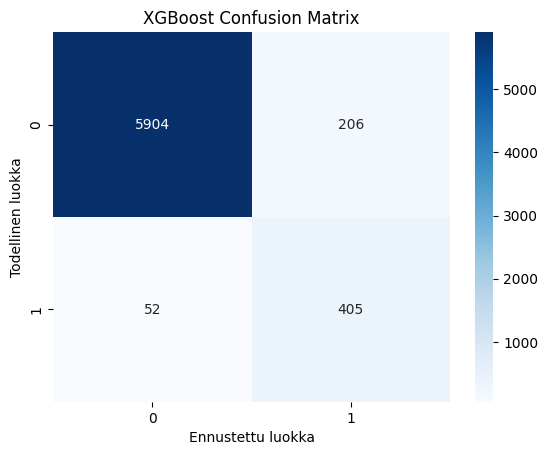

ROC AUC Score: 0.9881
Precision-Recall AUC: 0.8998


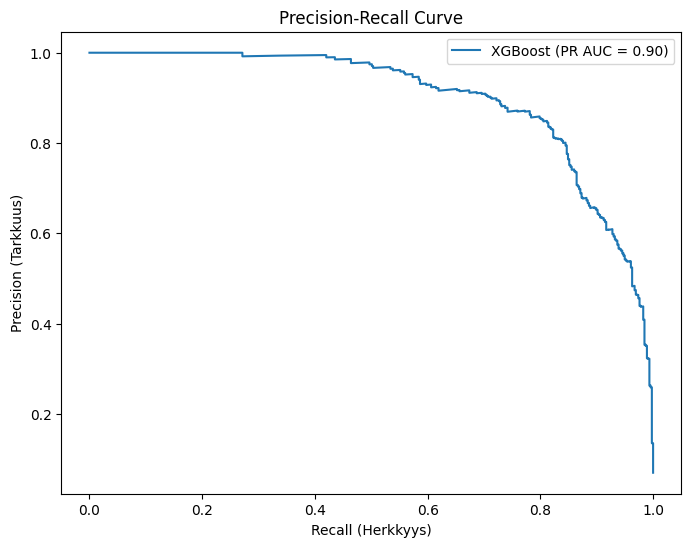


--- 9. Mallien vertailu ---
Tallennetut tulokset vertailua varten:
                          ROC_AUC    PR_AUC  F1_Spike  Recall_Spike  \
XGBoost (Default/Tuned)  0.988103  0.899819  0.758427           1.0   

                         Precision_Spike  
XGBoost (Default/Tuned)         0.069601  

Piirteiden tärkeys (Top 20):
                               Feature  Importance
9                  Otsoni__µg_m___lag1    0.331078
41         Otsoni__µg_m___roll_mean_3h    0.164183
10                 Otsoni__µg_m___lag2    0.026513
42          Otsoni__µg_m___roll_std_3h    0.026395
44          Otsoni__µg_m___roll_std_6h    0.018066
4                             hour_cos    0.017598
17      Lämpötilan_keskiarvo___C__lag1    0.015722
18      Lämpötilan_keskiarvo___C__lag2    0.015316
11                 Otsoni__µg_m___lag3    0.014704
0               Lämpötilan_keskiarvo_C    0.014588
8                            month_cos    0.014173
47        Otsoni__µg_m___roll_mean_24h    0.012819
38  Ilmanp

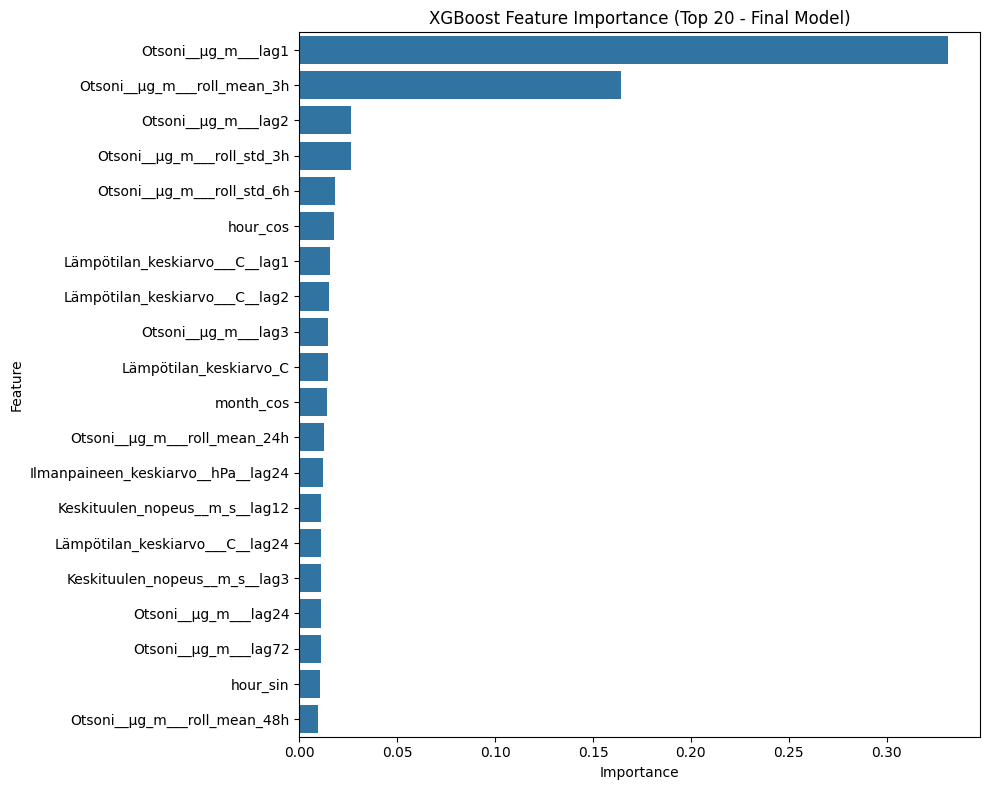


--- XGBoost-skripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for Ozone Spike Prediction using XGBoost - v6

Loads data, merges, resamples, engineers features, defines spikes,
trains a default XGBoost classifier, evaluates performance,
includes a framework for model comparison, and extensive comments.
Hyperparameter tuning section is commented out by default.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import xgboost as xgb
import re

# Koneoppimiskirjastot
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, make_scorer, f1_score

print("--- XGBoost Ozone Spike Prediction Script (v6 - Runnable with Comparison Framework) ---")

# --- Globaali sanakirja mallien vertailuun ---
# Tallennetaan eri mallien tärkeimmät metriikat tähän
model_comparison_metrics = {}

# --- Funktiot datan lataamiseen ja peruspuhdistukseen ---
def load_and_clean_data(raw_url, data_type='weather', cols_to_keep=None):
    """Lataa ja esikäsittelee datan, pitäen vain tarvittavat sarakkeet."""
    print(f"\nLadataan {data_type} dataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        # Valitaan oikea koodaus tiedostotyypin perusteella
        encoding = 'utf-8' if data_type == 'weather' else 'iso-8859-1'
        print(f"Lukeminen CSV:stä (encoding={encoding})...")
        csv_content = io.StringIO(response.content.decode(encoding))

        if data_type == 'ozone':
             # Kallion data vaatii erikoiskäsittelyn (skiprows, names, quoting, decimal=',')
             column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
             df_local = pd.read_csv(
                  csv_content, sep=',', decimal=',', skiprows=1, header=None,
                  names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False
             )
             target_col = "Otsoni [µg/m³]"
             if target_col in df_local.columns:
                  # read_csv hoiti jo desimaalimuunnoksen decimal=',' ansiosta
                  df_local[target_col] = pd.to_numeric(df_local[target_col], errors='coerce')
             else: raise ValueError(f"Otsonisarake '{target_col}' ei löytynyt.")

        elif data_type == 'weather':
            # Kaisaniemen data luetaan oletusasetuksin (header, sep=',', decimal='.')
            df_local = pd.read_csv(csv_content, sep=',', decimal='.', low_memory=False)
            df_local.columns = df_local.columns.str.strip() # Poista ylim. välilyönnit nimistä
            # Muunna vain tarvittavat sääsarakkeet numeroiksi
            weather_cols_to_convert = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']
            for col in weather_cols_to_convert:
                 if col in df_local.columns:
                      df_local[col] = pd.to_numeric(df_local[col], errors='coerce')

        else: raise ValueError(f"Tuntematon data_type: {data_type}")

        # Luo Timestamp yhtenäisellä logiikalla
        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols):
            raise ValueError(f"Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")

        # Muunna päivämääräkomponentit turvallisesti Int64 (käsittelee NaN) ja sitten str
        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64')
        df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64')
        df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any(): # Poista rivit, jos jokin komponentti puuttuu
            df_local.dropna(subset=required_dt_cols, inplace=True)

        df_local[year_col] = df_local[year_col].astype(str)
        df_local[month_col] = df_local[month_col].astype(str).str.zfill(2) # Varmista 2 numeroa (esim. '04')
        df_local[day_col] = df_local[day_col].astype(str).str.zfill(2) # Varmista 2 numeroa
        df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False) # Käsittele 24:00 -> 00:00
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce') # Muunna datetime-objektiksi
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1) # Korjaa päivämäärä 24:00 tapauksissa

        # Valitse vain pyydetyt sarakkeet + Timestamp
        cols_to_select = ['Timestamp'] + (cols_to_keep if cols_to_keep else [])
        missing_cols = [col for col in cols_to_select if col not in df_local.columns]
        if missing_cols: raise ValueError(f"Vaadittuja sarakkeita puuttuu datasta: {missing_cols}")
        df_local = df_local[cols_to_select].copy()

        # Poista rivit, joissa Timestamp tai jokin säilytettävä sarake on NaN
        df_local.dropna(subset=['Timestamp'] + (cols_to_keep if cols_to_keep else []), inplace=True)

        # Aseta Timestamp indeksiksi, lajittele ja poista duplikaatit
        df_local.set_index('Timestamp', inplace=True)
        df_local.sort_index(inplace=True)
        duplicates = df_local.index.duplicated(keep='first')
        if duplicates.sum() > 0: df_local = df_local[~duplicates]

        print(f"Datan ({data_type}) käsittely valmis, muoto: {df_local.shape}")
        if df_local.empty: print(f"VAROITUS: {data_type} DataFrame on tyhjä!")
        return df_local

    except requests.exceptions.RequestException as e: print(f"Virhe datan haussa URL:sta ({data_type}): {e}"); return None
    except Exception as e: print(f"Virhe datan käsittelyssä ({data_type}): {e}"); traceback.print_exc(); return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
weather_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"

o3_col = "Otsoni [µg/m³]"
weather_cols = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]']

df_ozone = load_and_clean_data(ozone_url, data_type='ozone', cols_to_keep=[o3_col])
df_weather = load_and_clean_data(weather_url, data_type='weather', cols_to_keep=weather_cols)

# --- 2. Datan yhdistäminen & RESAMPLE ---
df_merged = None
if df_ozone is not None and not df_ozone.empty and df_weather is not None and not df_weather.empty:
    print("\nYhdistetään otsoni- ja säädata...")
    df_merged_raw = pd.merge(df_ozone, df_weather, left_index=True, right_index=True, how='inner')
    print(f"Yhdistämisen jälkeen rivejä (raw): {len(df_merged_raw)}")
    df_merged_raw.dropna(inplace=True) # Varmistus NaN poistosta
    print(f"Rivejä NaN-poiston jälkeen (raw): {len(df_merged_raw)}")

    if not df_merged_raw.empty:
        print("Uudelleenotanta ('resample') tunneittaiseen taajuuteen...")
        # Luo säännöllinen tunti-indeksi ja laske keskiarvo (jos duplikaatteja)
        df_merged = df_merged_raw.resample('h').mean()
        print(f"Rivejä resamplen jälkeen: {len(df_merged)}")
        # Käsittele mahdolliset aukot interpoloimalla ajan suhteen
        nan_after_resample = df_merged.isnull().sum().sum()
        if nan_after_resample > 0:
            print(f"Löytyi {nan_after_resample} NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...")
            df_merged.interpolate(method='time', inplace=True)
            # Täytä mahdolliset alku-/loppu-NaN:t edellisellä/seuraavalla arvolla
            remaining_nan = df_merged.isnull().sum().sum()
            if remaining_nan > 0:
                 print(f"Varoitus: Jäljellä {remaining_nan} NaN-arvoa interpoloinnin jälkeen. Täytetään (ffill/bfill)...")
                 df_merged.fillna(method='ffill', inplace=True)
                 df_merged.fillna(method='bfill', inplace=True)
        # Viimeinen tarkistus ja mahdollisten jäljelle jääneiden NaN-rivien poisto
        if df_merged.isnull().any().any():
             print("VAROITUS: NaN-arvoja jäi datan käsittelyn jälkeen! Poistetaan rivit.")
             df_merged.dropna(inplace=True)
        if df_merged.empty: df_merged = None
        else: print("Datan yhdistäminen ja resample onnistui.")
    else: df_merged = None

# Jatka vain jos data ok
if df_merged is not None:

    # --- 3. Piikkien määrittely ---
    print("\n--- 3. Piikkien määrittely ---")
    # Käytetään 90. persentiiliä raja-arvona piikille
    spike_threshold = df_merged[o3_col].quantile(0.90)
    # Luo binäärinen kohdemuuttuja: 1 = piikki, 0 = ei piikkiä
    df_merged['onko_piikki'] = (df_merged[o3_col] > spike_threshold).astype(int)
    print(f"Piikin kynnysarvo ({0.90*100:.0f}. persentiili): {spike_threshold:.2f} µg/m³")
    print(f"Piikkejä löytyi datasta: {df_merged['onko_piikki'].sum()} kpl ({df_merged['onko_piikki'].mean()*100:.2f} % datasta)")

    # --- 4. Piirteiden muokkaus (Feature Engineering) ---
    print("\n--- 4. Piirteiden muokkaus ---")
    # Tässä luodaan uusia sarakkeita (piirteitä), jotka auttavat mallia ymmärtämään
    # ajallisia riippuvuuksia ja kausivaihteluita, joita perus-ML-malli ei itse tunnista.

    # 4a. Aikaan perustuvat piirteet (sykliset)
    print("Luodaan aikaan perustuvia piirteitä (sin/cos)...")
    # Muunnetaan sykliset piirteet (tunti, viikonpäivä, kuukausi) sini/kosini-pareiksi,
    # jotta malli ymmärtää niiden jatkuvuuden (esim. tunti 23 on lähellä tuntia 0).
    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged.index.hour / 24)
    df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged.index.hour / 24)
    df_merged['dayofweek_sin'] = np.sin(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['dayofweek_cos'] = np.cos(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged.index.month / 12)
    df_merged['month_cos'] = np.cos(2 * np.pi * df_merged.index.month / 12)

    # 4b. Viiveistetyt piirteet (Lags)
    # Lisätään tietoa edellisten tuntien arvoista.
    features_to_lag = [o3_col] + weather_cols
    lag_periods = [1, 2, 3, 6, 12, 24, 48, 72] # Tuntia taaksepäin
    print(f"Luodaan viivepiirteet {lag_periods} tunnin jaksoilla...")
    for col in features_to_lag:
        for lag in lag_periods:
            sanitized_col_name = re.sub(r'[\[\]<>°/³\s]', '_', col)
            df_merged[f'{sanitized_col_name}_lag{lag}'] = df_merged[col].shift(lag)

    # 4c. Liukuvat keskiarvot/tilastot (Rolling features)
    # Lasketaan tilastoja (keskiarvo, keskihajonta) tietyn pituisista menneistä jaksoista.
    rolling_window_hours = [3, 6, 12, 24, 48]
    print(f"Luodaan liukuvia tilastoja {rolling_window_hours} tunnin ikkunoilla...")
    for window in rolling_window_hours:
        shifted_o3 = df_merged[o3_col].shift(1) # shift(1) estää nykyhetken datavuodon
        sanitized_o3_col_name = re.sub(r'[\[\]<>°/³\s]', '_', o3_col)
        df_merged[f'{sanitized_o3_col_name}_roll_mean_{window}h'] = shifted_o3.rolling(window=window).mean()
        df_merged[f'{sanitized_o3_col_name}_roll_std_{window}h'] = shifted_o3.rolling(window=window).std()

    # Poista NaN-arvot, jotka syntyivät viiveiden ja liukuvien keskiarvojen luonnista
    initial_rows = len(df_merged)
    df_merged.dropna(inplace=True)
    print(f"Poistettu {initial_rows - len(df_merged)} riviä piirteiden muokkauksen jälkeen (NaN-arvojen vuoksi).")

    if df_merged.empty: print("Virhe: Data tyhjä piirteiden muokkauksen jälkeen."); df_merged = None

if df_merged is not None:
    # --- 5. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 5. Datan jako opetus- ja testijoukkoihin ---")
    target = 'onko_piikki'
    # Poistetaan alkuperäinen otsonipitoisuus piirteistä, koska ennustamme piikkiä (0/1)
    features_orig_names = [col for col in df_merged.columns if col not in [o3_col, target]]
    X = df_merged[features_orig_names]
    y = df_merged[target]

    # Puhdistetaan sarakkeiden nimet XGBoostia varten (poistaa erikoismerkit)
    print("Puhdistetaan sarakkeiden nimet XGBoostia varten...")
    def sanitize_col_names(df_or_list):
        if isinstance(df_or_list, pd.DataFrame): cols = df_or_list.columns
        elif isinstance(df_or_list, list): cols = df_or_list
        else: return df_or_list
        new_cols = []
        for col in cols:
            new_col = str(col); new_col = re.sub(r'[\[\]<>°/³]', '', new_col); new_col = re.sub(r'\s+', '_', new_col)
            new_cols.append(new_col)
        if isinstance(df_or_list, pd.DataFrame): df_or_list.columns = new_cols; return df_or_list
        elif isinstance(df_or_list, list): return new_cols
    X = sanitize_col_names(X.copy())
    features = X.columns.tolist() # Päivitä piirteiden lista puhdistetuilla nimillä
    print("Sarakkeiden nimet puhdistettu.")

    # Ajallinen jako: Käytetään esim. 85% opetusdataan, 15% testidataan
    test_size = 0.15
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    print(f"Opetusdata: {X_train.index.min()} - {X_train.index.max()} ({len(X_train)} riviä)")
    print(f"Testidata: {X_test.index.min()} - {X_test.index.max()} ({len(X_test)} riviä)")
    print(f"Piikkejä opetusdatassa: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
    print(f"Piikkejä testidatassa: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

    # --- 6. Piirteiden skaalaus ---
    print("\n--- 6. Skaalataan piirteet ---")
    # Skaalataan piirteet keskiarvoon 0 ja keskihajontaan 1.
    # Vaikka XGBoost ei vaadi skaalausta, se ei yleensä haittaakaan ja voi joskus auttaa.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # Sovita ja muunna opetusdata
    X_test_scaled = scaler.transform(X_test)      # Muunna testidata samalla skaalaimella
    # Säilytetään DataFrame-muoto ja puhdistetut sarakenimet
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=features)
    print("Skaalaus valmis.")

    # --- 7. XGBoost Hyperparametrien viritys (Hahmotelma) ---
    print("\n--- 7. XGBoost Hyperparametrien viritys (Hahmotelma - kommentoitu pois) ---")
    # Tässä osiossa voit poistaa kommentit ajaaksesi hyperparametrien haun.
    # HUOM: Ajo voi kestää kauan!
    run_hyperparameter_search = False # Aseta True ajaaksesi haun

    if run_hyperparameter_search:
        param_grid = {
            'n_estimators': [100, 200, 300, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9], 'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 'gamma': [0, 0.1, 0.5, 1],
            'reg_alpha': [0, 0.01, 0.1, 1], 'reg_lambda': [0.1, 1, 5, 10] }
        tscv = TimeSeriesSplit(n_splits=5)
        # Käytetään F1-scorea piikeille (pos_label=1) optimointiin
        f1_scorer_spike = make_scorer(f1_score, pos_label=1)
        base_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=ratio, random_state=42, n_jobs=-1)
        xgb_search = RandomizedSearchCV(estimator=base_xgb, param_distributions=param_grid, n_iter=50,
                                        scoring=f1_scorer_spike, cv=tscv, n_jobs=-1, verbose=1, random_state=42)
        print("Aloitetaan hyperparametrien haku (RandomizedSearchCV)...")
        # Käytä skaalattua dataa haussa
        xgb_search.fit(X_train_scaled, y_train)
        print(f"Parhaat parametrit löydetty: {xgb_search.best_params_}")
        print(f"Paras F1-score (piikki) ristiinvalidoinnissa: {xgb_search.best_score_:.4f}")
        best_xgb_params = xgb_search.best_params_
    else:
        print("Ohitetaan hyperparametrien haku, käytetään oletusparametreja.")
        # Käytetään samoja oletuksia kuin aiemmin, jos hakua ei ajeta
        best_xgb_params = { 'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100,
                            'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8 }
        # Voit muokata näitä manuaalisesti, jos haluat kokeilla eri arvoja nopeasti

    # --- 8. XGBoost-mallin koulutus ja evaluointi (Parhailla/Oletusparametreilla) ---
    print("\n--- 8. XGBoost-mallin koulutus ja evaluointi ---")
    try:
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1) if np.sum(y_train == 1) > 0 else 1
        print(f"Käytetään scale_pos_weight: {ratio:.2f} (tasapainottaa luokkia)")

        # Alusta malli parhailla/oletusparametreilla
        xgb_model_final = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=ratio,
            random_state=42,
            n_jobs=-1,
            **best_xgb_params # Välitä parhaat/oletusparametrit
        )

        print(f"Koulutetaan lopullista XGBoost-mallia parametreilla: {best_xgb_params}...")
        xgb_model_final.fit(X_train_scaled, y_train, verbose=False) # Ei early stoppingia tässä vaiheessa
        print("Malli koulutettu.")

        # Tee ennusteet testidatalle
        y_pred_xgb = xgb_model_final.predict(X_test_scaled)
        y_pred_proba_xgb = xgb_model_final.predict_proba(X_test_scaled)[:, 1]

        # Evaluoi luokittelija
        print("\nLopullisen XGBoost-luokittelijan evaluointi:")
        print(classification_report(y_test, y_pred_xgb, zero_division=0))
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred_xgb)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Ennustettu luokka')
        plt.ylabel('Todellinen luokka')
        plt.title('XGBoost Confusion Matrix')
        plt.show()

        # Lasketaan ja tallennetaan metriikat vertailua varten
        roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
        pr_auc = auc(recall, precision)
        f1_spike = f1_score(y_test, y_pred_xgb, pos_label=1) # F1 piikeille

        print(f"ROC AUC Score: {roc_auc:.4f}")
        print(f"Precision-Recall AUC: {pr_auc:.4f}")

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'XGBoost (PR AUC = {pr_auc:.2f})')
        plt.xlabel('Recall (Herkkyys)')
        plt.ylabel('Precision (Tarkkuus)')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

        # --- 9. Mallien vertailu ---
        print("\n--- 9. Mallien vertailu ---")
        # Lisätään tämän mallin tulokset vertailuun
        model_name = 'XGBoost (Default/Tuned)' # Muuta nimeä jos ajoit virityksen
        model_comparison_metrics[model_name] = {
            'ROC_AUC': roc_auc,
            'PR_AUC': pr_auc,
            'F1_Spike': f1_spike,
            # Voit lisätä muita metriikoita classification_reportista, esim. accuracy, recall_spike, precision_spike
            'Recall_Spike': recall[1] if len(recall) > 1 else f1_score(y_test, y_pred_xgb, pos_label=1, average=None)[1], # Haetaan recall luokalle 1
            'Precision_Spike': precision[1] if len(precision) > 1 else f1_score(y_test, y_pred_xgb, pos_label=1, average=None)[0] # Haetaan precision luokalle 1
        }
        print("Tallennetut tulokset vertailua varten:")
        comparison_df = pd.DataFrame.from_dict(model_comparison_metrics, orient='index')
        print(comparison_df)


        # Piirteiden tärkeys
        try:
            if hasattr(xgb_model_final, 'feature_importances_'):
                 feature_importance_df = pd.DataFrame({
                     'Feature': features,
                     'Importance': xgb_model_final.feature_importances_
                 }).sort_values(by='Importance', ascending=False)
                 print("\nPiirteiden tärkeys (Top 20):")
                 print(feature_importance_df.head(20))
                 plt.figure(figsize=(10, 8))
                 sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
                 plt.title('XGBoost Feature Importance (Top 20 - Final Model)')
                 plt.tight_layout()
                 plt.show()
            else: print("Piirteiden tärkeyksiä ei voitu hakea mallista.")
        except Exception as e_imp: print(f"Virhe piirteiden tärkeyden näyttämisessä: {e_imp}")

    except Exception as e_xgb:
        print(f"Virhe XGBoost-mallin ajossa: {e_xgb}")
        traceback.print_exc()

else: # df_merged is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan yhdistäminen/muokkaus epäonnistui.")


print("\n--- XGBoost-skripti päättyi ---")